# Plot correspondences in registration

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import ipywidgets as ipyw
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import loadmat
from IPython.display import HTML

from otimage import imagerep, readers
from otimage.utils import plot_maxproj
from otimage.imagereg import ot_registration, gw_registration

## Load Zimmer data

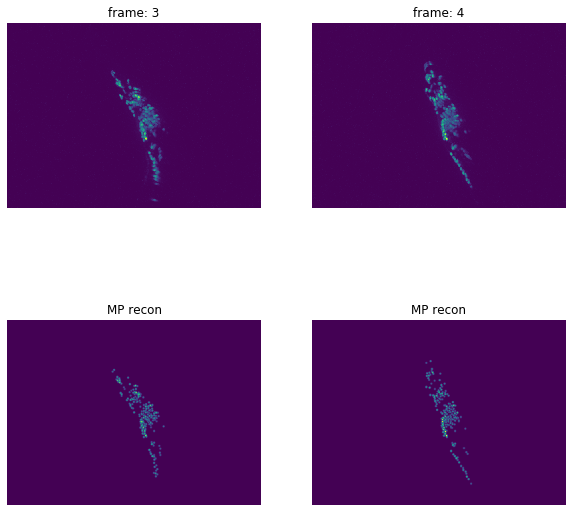

In [3]:
# Frame index
t1 = 3
t2 = 4

# Load two successive frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with readers.ZimmerReader(img_path) as reader:
    img_1 = reader.get_frame(t1)
    img_2 = reader.get_frame(t2)
    img_shape = img_1.shape

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.mat'
mp_data = loadmat(mp_path)
cov = mp_data['cov']
pts_1 = mp_data['means'][t1, :, :]
pts_2 = mp_data['means'][t2, :, :]
wts_1 = mp_data['weights'][t1, :, 0]
wts_2 = mp_data['weights'][t2, :, 0]
n_mps = pts_1.shape[0]

# Reconstruct images from MPs
rec_1 = imagerep.reconstruct_image(pts_1, [cov], wts_1, img_shape)
rec_2 = imagerep.reconstruct_image(pts_2, [cov], wts_2, img_shape)
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj(img_1)
plt.title(f'frame: {t1}')
plt.axis('off')

plt.subplot(222)
plot_maxproj(img_2)
plt.title(f'frame: {t2}')
plt.axis('off');

plt.subplot(223)
plot_maxproj(rec_1)
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj(rec_2)
plt.title('MP recon')
plt.axis('off');

## Compute registration for images

In [4]:
degree = 2
n_iter = 50

model, debug = gw_registration(pts_1, pts_2, wts_1, wts_2, degree=degree, n_iter=n_iter)

beta = model.named_steps['linear'].coef_
print('beta (est):')
print(beta)

beta (est):
[[ 2.43017613e+03 -6.38992436e+00 -4.01161799e+00 -1.35714644e+00
   5.77663974e-03  5.42202777e-03 -2.14474482e-03  2.25017303e-03
   2.51108530e-03  5.36304017e-02]
 [ 4.95143482e+02 -2.37261249e+00  1.40922926e+00  4.96883463e+00
   2.53376314e-03 -1.82022110e-04 -7.15502526e-03 -4.55521427e-04
  -3.20580516e-03 -1.74532707e-02]
 [ 6.02670950e+02 -1.78935317e+00 -9.05250343e-01 -1.63380816e+00
   1.32693901e-03  1.44182594e-03  3.50285368e-03  2.92155394e-04
   1.18662463e-03 -1.12024097e-02]]


## Compute pushforward with identified MP component

In [5]:
# Transform MP points for first image using mapping
pf_pts = model.predict(pts_1).astype(int)

# Reconstruct image from transformed points
#rec_pf = imagerep.reconstruct_image_2(pf_pts, wts_1, cov, img_shape)

## Plot color-coded correspondence

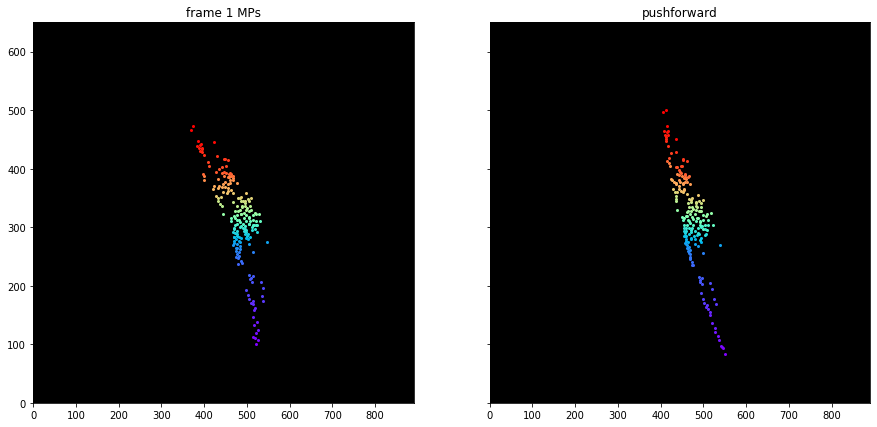

In [13]:
colors = cm.rainbow(np.linspace(0, 1, n_mps))

idx = np.lexsort((pts_1[:, 0], pts_1[:, 1]))
pts_plot_1 = pts_1[idx]
pts_plot_pf = pf_pts[idx]

subplot_kw = {
    'facecolor': 'black',
    'xlim': [0, img_shape[0]],
    'ylim': [0, img_shape[1]],
}
fig, (ax_1, ax_2) = plt.subplots(
    1, 2, sharex=True, sharey=True, subplot_kw=subplot_kw, figsize=(15, 7))

ax_1.set_title('frame 1 MPs')
for pt, color in zip(pts_plot_1, colors):
    ax_1.plot(pt[0], pt[1], color=color, marker='o', markersize=2)

ax_2.set_title('pushforward')
for pt, color in zip(pts_plot_pf, colors):
    ax_2.plot(pt[0], pt[1], color=color, marker='o', markersize=2)